# Linear Regression

Today we will start working on our first Machine Learning model: Linear Regression.

# Table of contents
[1. Linear Regression](#1.-Linear-Regression)
- [1.1 Linear regression for income in Year 1 using parents' average age at the time of birth as predictor](#1.1-Linear-regression-for-income-in-Year-1-using-parents'-average-age-at-the-time-of-birth-as-predictor)
- [1.2 Plotting the data](#1.2-Plotting-the-data)
- [1.3 Splitting data into train and test sets](#1.3-Splitting-data-into-train-and-test-sets)
- [1.4 Running the linear regression algorithm](#1.4-Running-the-linear-regression-algorithm)
- [1.5 Evaluation and generalization](#1.5-Evaluation-and-generalization)


[2. Multivariate Regression](#2.-Multivariate-Regression)
- [2.1 Multiple linear regression for income in Year 1 using mother's and father's ages at the time of birth as predictor](#2.1-Multiple-linear-regression-for-income-in Year-1-using-mother's-and-father's-ages-at-the-time-of-birth-as-predictor)
- [2.2 Plotting the data](#2.2-Plotting-the-data)
- [2.3 Splitting data into train and test sets](#2.3-Splitting-data-into-train-and-test-sets)
- [2.4 Running the multiple linear regression algorithm](#2.4-Running-the-multiple-linear-regression-algorithm)
- [2.5 Evaluation and generalization](#2.5-Evaluation-and-generalization)



# 1. Linear Regression

Linear regression is a linear approach to modelling the relationship between a continuous variable (called the outcome or the dependent variable) and one explanatory variable (called predictor or independent variable). 

In linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. The term "best-fit" refers to the fact that the resulting line minimizes the squared distance between the data points and the line. 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X + error$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, $c_1$ is the regression coefficient that tells us by how much $Y$ changes when $X$ is not zero. For now, we will set error to zero, meaning we will ignore the effects of noise. The resulting equation $Y = c_0 + c_1 X$ is just the equation for a line with $c_0$ as its y-intercept and $c_1$ is its slope. 

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the value of $X$.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import sys
# this library provides functions for performing statistics on data
import sklearn
import ff_functions as fff

In [2]:
# Read in data
background = "../../ai4all_data/background.csv"
data_frame = pd.read_csv(background, low_memory=False)
data_frame = data_frame.set_index('challengeID')

# 1.1 Linear regression for income in Year 1 using parents' average age at the time of birth as predictor 
In this section we will build a linear regression model to predict the family's income in year 2 ('f2l1'). As a predictor, we will use a new engineered feature, which combines the mother's age at the time of child's birth (feature 'cm1age') and the father's age at the time of child's birth (feature 'cf1age')

In [3]:
age_income = fff.pick_ff_variables(data_frame, ["cm1age", "cf1age", "f2l1"], remove_nans=True, remove_negatives=True)

# Let's change the names of the columns so it's easier for us to work with the data
age_income.columns = ["Mother_age_0", "Father_age_0", "Year_1_income"]

age_income.head()

Data frame with  1386  rows and  3 columns.


,Mother_age_0,Father_age_0,Year_1_income
challengeID,,,
4,22,24,31037.239985
6,18,20,37215.440460
9,21,24,23437.652319
11,22,31,19508.401102
13,22,22,26212.061488


Let's create a new feature that captures the parents' average age - after all, the income is provided per the entire family.

(Recall "feature engineering" - the last part in lecture 3.1)

In [4]:
age_income["average_age"] = age_income.Mother_age_0*0.5 + age_income.Father_age_0*0.5
age_income.head()

,Mother_age_0,Father_age_0,Year_1_income,average_age
challengeID,,,,
4,22,24,31037.239985,23.0
6,18,20,37215.440460,19.0
9,21,24,23437.652319,22.5
11,22,31,19508.401102,26.5
13,22,22,26212.061488,22.0


# 1.2 Plotting the data
Let's plot the data using the scatterplot function we learned.

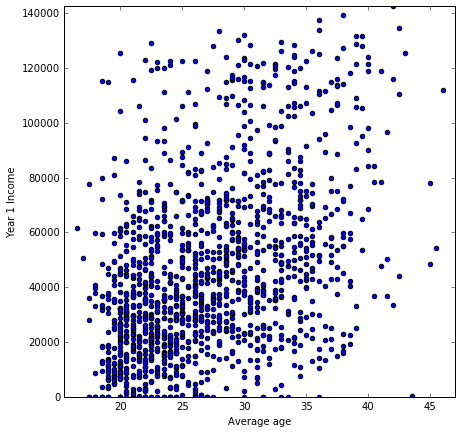

In [5]:
fff.scatterplot(age_income.average_age, age_income.Year_1_income, xlabel = "Average age", ylabel = "Year 1 Income")

# 1.3 Splitting data into train and test sets

In [6]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split

X = age_income.average_age # predictor
y = age_income.Year_1_income # outcome 
# this function randomly picks a portion (in our case 0.3)
# of all indices and puts them in "test" - the rest goes into "train"
# don't worry about the random_state argument for now
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=100)

print(age_income.shape)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1386, 4)
(970,)
(416,)
(970,)
(416,)


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
train_X.head()

challengeID
2660    35.5
3355    28.0
1519    21.0
2983    26.0
1387    33.5
Name: average_age, dtype: float64

The train_X displays differently: that's because 1-column DataFrames are by default consitered as another one of Pandas objects: Series. (https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.html).

In [8]:
train_X.shape

(970,)

Notice that the shape of a Series is missing the second dimension. This is because Series are always 1-dimensional (only one column for many rows).

We'll be using the sklearn package to perform linear regression (http://scikit-learn.org/)

Sklearn functions take in 2D numpy arrays rather than 1D Pandas Series. Let's convert our Series such that we can run them with sklearn. 

In [9]:
# change the format of train_X and train_y so sklearn doesn't complain
'''
This function converts a pandas 1D series to a numpy 2D array (for reference, see lecture 2.2),
which can be used with sklearn functions
'''
def pandas_to_2d_numpy(pandas_df):
    num_rows = pandas_df.shape[0]
    # cast the Pandas Series to a numpy array (because sklearn works with numpy)
    numpy_df = np.array(pandas_df) # remove title
    # expand the number of dimensions (from (d,0) to (d,1)) - 1d list to 2d list
    if len(pandas_df.shape) == 1:
        numpy_df = numpy_df.reshape(num_rows,1)
    return numpy_df

numpy_train_X = pandas_to_2d_numpy(train_X)
numpy_train_y = pandas_to_2d_numpy(train_y)

numpy_test_X = pandas_to_2d_numpy(test_X)
numpy_test_y = pandas_to_2d_numpy(test_y)

# 1.4 Running the linear regression algorithm

**Let's do linear regression with `sklearn.linear_model.LinearRegression`** You can learn about this function at 
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


slope = 2434.5707092599737
y-intercept = -20213.27416454086


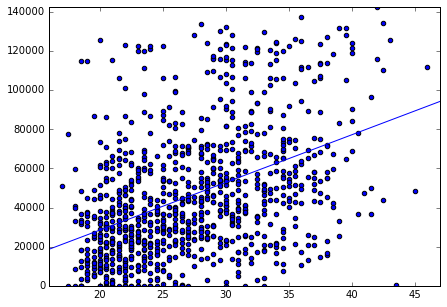

In [10]:
# import the linear_model function from sklearn
from sklearn import linear_model

# intialize the model
reg = linear_model.LinearRegression()

# fit the model ON THE TRAIN DATA (important!)
reg.fit(numpy_train_X, numpy_train_y)

# select slope and intercept values
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# print the generated coefficients
print('slope = {}'.format(slope))
print('y-intercept = {}'.format(intercept))

# we plot the regression line along with the data points 
# (for a full description of this edited scatterplot, see ff_functions.py)
fff.scatterplot_with_line(numpy_train_X, numpy_train_y, slope, intercept)

### Question 1.4.1
Notice that the y intercept is below 0, but on the graph it crosses the y axis above zero. Why?
(Hint: look at the x axis scale)

### Answer:

# 1.5 Evaluation and generalization
We will use the mean squared error to evaluate the performance of our algorithm (always on the test data).

In [11]:
# calculate mean square error ON THE TEST DATA
test_prediction = slope*test_X + intercept
test_real = test_y

### Problem 1.5.1 (difficult!)
Calculate your own mean squared error without using sklearn.

$$MSE = \frac{1}{n}\sum^n_{i=1}(real_i-predicted_i)^2$$

As well as your own *root* mean squared error without using sklearn.

$$RMSE = \sqrt{MSE}$$
(Hint: you can check if your answer is correct by comparing it to the sklearn output:

`test_sklearn_mse = sklearn.metrics.mean_squared_error(test_real, test_prediction)`

`test_sklearn_rmse = np.sqrt(test_sklearn_mse)`

)

In [12]:
test_mse = 0
##################### TODO: remove this ######################
test_mse = np.mean(((test_real-test_prediction) ** 2))
test_rmse = np.sqrt(test_mse)
##################### TODO: remove this ######################

In [13]:
print('mean square error : {}'.format(test_mse))
print('mean root of square error : {}'.format(test_rmse))

mean square error : 820686116.0494226
mean root of square error : 28647.619727464666


Visualize the best fit line calculated on the TRAIN data along with the TEST data scatterplot.

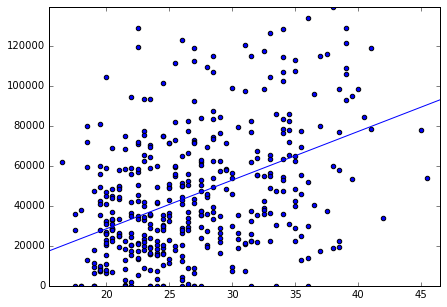

In [14]:
fff.scatterplot_with_line(test_X,test_y, slope, intercept)

Now, as a sanity check, calculate mean square error ON THE TRAIN DATA. This is often useful, to see how well our algorithm learned to approximate the data it was trained on. This is **not the same as algorithm performance** - we always need to mention that we're providing the **performance on training set ** in this case.


In [15]:
train_prediction = slope*train_X + intercept
train_real = train_y

##################### TODO: remove this ######################
train_mse = np.mean(((train_real-train_prediction) ** 2))
train_rmse = np.sqrt(train_mse)
##################### TODO: remove this ######################

print('mean square error : {}'.format(train_mse))
print('mean root of square error : {}'.format(train_rmse))

mean square error : 847504887.8271332
mean root of square error : 29111.937204987462


### Question 1.5.1:
Compare the performance on train and test data. Does the algorithm generalize well? 
### Answer:

### Problem 1.5.2
Run regression of family income in year 1 vs just Father's age ('f2l1' vs 'cf1age')

(hint: Repeat the following steps:)

* plot the data
* create a train and test split
* convert the splits to numpy arrays using **`fff.pandas_to_2d_numpy(pandas_series)`**
* train the regression model on the train data
* test the regression model on the test data
* test the regression model on the train data (for sanity check)
* does the algorithm generalize well?
* compare the performance of our new algorithm to the previous one


### Problem 1.5.3
Do the same for income in year 1 vs just Mother's age ('f2l1' vs 'cm1age').

Which variable was a better predictor?
* does the algorithm generalize well?
* compare the performance of our new algorithm to the previous one

### Question 1.5.2
Of the three algorithms we tried:
- parents' average age vs income
- father's age vs income
- mother's age vs income

Which one has the best performance? Why do you think this may be?

Which one generalizes best?

# 2. Multiple Linear Regression

Multiple linear regression is a generalization of linear regression. In multiple linear regression we model the relationship between a continuous variable (called the outcome or the dependent variable) and multiple explanatory variables (called predictors or independent variables). 

As in linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. However, we use a different equation for the best-fit line which takes into account the effects of multiple predictors $X_1,X_2,\dots,X_n$: 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \dots + c_n X_n + \epsilon$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, and $c_i$ where $i = 1,2,3,\dots,n$ is the regression coefficient that tells us by how much $Y$ changes when the predictor $X_i$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the values of $X_i$.

# 2.1 Multiple linear regression for income in Year 1 using mother's and father's ages at the time of birth as predictor 
In this section we will build a multiple linear regression model to predict the family's income in year 2 ('f2l1'). As a predictor, we will use the mother's age at the time of child's birth (feature 'cm1age') as well as father's age at the time of child's birth (feature 'cf1age').

Let's remind ourselves what the data frame looks like:

In [16]:
age_income.head()

,Mother_age_0,Father_age_0,Year_1_income,average_age
challengeID,,,,
4,22,24,31037.239985,23.0
6,18,20,37215.440460,19.0
9,21,24,23437.652319,22.5
11,22,31,19508.401102,26.5
13,22,22,26212.061488,22.0


# 2.2 Plotting the data
We can visualize the mother's age, father's age and income in one 3D plot (which can also be found by calling **`fff.scatter_3d()`**). 

In [17]:
from mpl_toolkits.mplot3d import Axes3D

'''
This function takes in three arrays of equal length (xdata, ydata, zdata)
and plots them against each other in a 3D scatterplot

Required:
xdata: a column of a Pandas DataFrame, data to be plotted against the x axis
ydata: a column of a Pandas DataFrame, data to be plotted against the y axis
xdata: a column of a Pandas DataFrame, data to be plotted against the x axis
(must all be same length)

Additional (with default values filled in):
xlabel: label for the x axis (string)
ylabel: label for the y axis (string)
zlabel: label for the z axis (string)
title: plot title (string)
slope: 2d list with x and y slopes, to plot a line
intercept: a float or int with z-intercept, to plot a line
'''
def scatter_3d(xdata, ydata, zdata, xlabel="", ylabel="", zlabel="", title="", slope=None, intercept=None):
    
    # choose figure size
    fig = plt.figure(figsize=(7,7))
    
    # create a "subplot" and make it 3d
    ax = fig.add_subplot(111, projection='3d')
    ax.axis('equal')
    
    # plot the data
    ax.scatter(xdata, ydata, zdata)
    
    # set the selected labels for x and y axes, and title (empty by default)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    
    # optionally: draw a line, when slope and intercept provided
    if (slope is not None) and (intercept is not None):
        x = np.linspace(min(xdata)-1,max(xdata)+1, 100)
        y = np.linspace(min(ydata)-1,max(ydata)+1, 100)
        ax.plot(x, y, slope[0]*x+slope[1]*y+intercept)

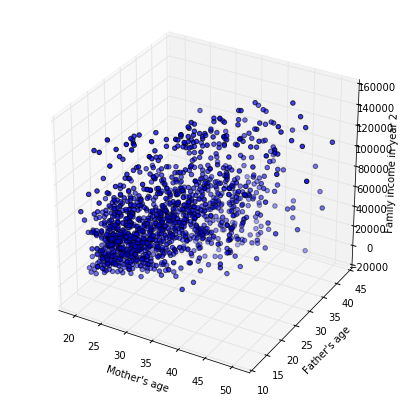

In [18]:
scatter_3d(age_income.Father_age_0, age_income.Mother_age_0, age_income.Year_1_income, xlabel="Mother's age", \
           ylabel="Father's age", zlabel = "Family income in year 2")

# 2.3 Splitting data into train and test sets
Let's again split our data into train and test sets, and try to find the best fit line.

In [19]:
# Split our data into train and test sets
from sklearn.cross_validation import train_test_split

X = age_income[["Mother_age_0","Father_age_0"]] # predictor
y = age_income[["Year_1_income"]] # outcome 

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=100)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(970, 2)
(416, 2)
(970, 1)
(416, 1)


In [20]:
multi_numpy_train_X = pandas_to_2d_numpy(train_X)
multi_numpy_train_y = pandas_to_2d_numpy(train_y)

multi_numpy_test_X = pandas_to_2d_numpy(test_X)
multi_numpy_test_y = pandas_to_2d_numpy(test_y)

# 2.4 Running the multiple linear regression algorithm
In this section, we'll again use `sklearn.linear_model.LinearRegression` to do multiple linear regression.

In [21]:
# fit the linear regression model and get the slope and intercept
multireg = linear_model.LinearRegression()
multireg.fit(multi_numpy_train_X, multi_numpy_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We denote $X$ and $Y$ as two features `Mother_age_0` and `Father_age_0`. Then the multiple regression model can be written as 

$Z = \text{z_intercept} + \text{x_slope}*\text{X} + \text{y_slope}*\text{Y} + \epsilon$

The coefficients can be retrieved from the fitted model.


In [22]:
# select slope and intercept values
slope = multireg.coef_[0]
intercept = multireg.intercept_[0]

# print the generated coefficients
print('[x_slope, y_slope] = {}'.format(slope))
print('z-intercept = {}'.format(intercept))

[x_slope, y_slope] = [ 2472.59644572    96.89322771]
z-intercept = -20074.639615040076


### Question 2.4.1
Is the mother's age or the father's age more important in predicting the income?

### Answer:

Plot the 3D scatterplot with the slope and intercept

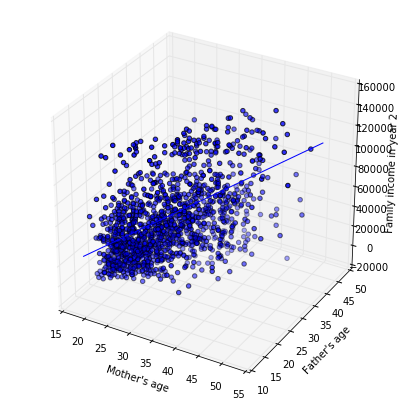

In [23]:
scatter_3d(age_income.Father_age_0, age_income.Mother_age_0, age_income.Year_1_income, xlabel="Mother's age", \
           ylabel="Father's age", zlabel = "Family income in year 2", slope=slope, intercept=intercept)

# 2.5 Evaluation and generalization

We can use this model to predict the income for parents in the test set.

In [25]:
test_prediction = slope[0]*multi_numpy_test_X[:,0]+slope[1]*multi_numpy_test_X[:,1]+intercept
test_real = multi_numpy_test_y

test_y_predict = multireg.predict(multi_numpy_test_X)

# calculate mean squared error
test_sklearn_mse = sklearn.metrics.mean_squared_error(test_real, test_y_predict)

# calculate root of mean square error
test_sklearn_rmse = np.sqrt(test_sklearn_mse)

print('multiple regression results on TEST data')
print('mean square error of prediction : {}'.format(test_sklearn_mse))
print('mean root of mean square error : {}'.format(test_sklearn_rmse))

multiple regression results on TEST data
mean square error of prediction : 838571081.9392604
mean root of mean square error : 28958.091821445356


Now, as a sanity check, calculate mean square error ON THE TRAIN DATA.

In [26]:
train_prediction = slope[0]*multi_numpy_train_X[:,0]+slope[1]*multi_numpy_train_X[:,1]+intercept
train_real = multi_numpy_train_y

train_y_predict = multireg.predict(multi_numpy_train_X)
train_sklearn_mse = sklearn.metrics.mean_squared_error(train_real, train_y_predict)
train_sklearn_rmse = np.sqrt(test_sklearn_mse)

print('multiple regression results on TRAIN data')
print('mean square error of prediction : {}'.format(train_sklearn_mse))
print('mean root of mean square error : {}'.format(train_sklearn_rmse))

multiple regression results on TRAIN data
mean square error of prediction : 829676385.0158875
mean root of mean square error : 28958.091821445356


### Question 2.5.1:
Compare the performance on train and test data. Does the algorithm generalize well? Are the results better or worse than at our earlier (non-multiple-regression) attempts?
### Answer:

### Question 2.5.2:
We use parents' age at the child's birth to predict income in year 2 - what would change if we instead used parents' age in year 2?

### Answer:

## TODO: Problem
Redo the same with removing unmarried couples

## TODO: Problem
Back to regular linear regression. Create a feature where you reweigh the mother's and father's age in the ratio that comes out of the multiple regression. Run regression now. Did results improve? Are they similar to multiple regression? Why?